In this project we will create a Convolutional Neural Network which will be able to predict whether a plant is suffering from a disease. We will use different layers and other hyperparameters for building, training and testing this classifictaion model.We will be using tensorflow and keras for this project.

**First we will mount our google drive on colab so that we can use the dataset directly from our drive. For this you first need to upload the data on your drive and then mount the drive on colab.**

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**After mounting our drive we will locate the folder where our data is stored to use it in our colab notebook.
Here you can see that I have some folders in my drive and 'Plant_images_Try'  contains the images that we will work on.**

In [ ]:
# After executing the cell above, Drive
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive"

 Classroom		       docs		  Plant_images_pianalytix   plant_model_weights.h5
'Colab Notebooks'	       plant_disease.h5   Plant_images_Try
'Copy of BB+ Curriculum.pdf'   Plant_Images_Lim   plant_model.json


**Next we will import all the required libraries. As we are making a CNN model we will import all the required layers, activations, optimizers, etc.**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
import os
from os import listdir
from PIL import Image
from sklearn.preprocessing import label_binarize,  LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


**Now we will observe some of the iamges that are their in our dataset. We will plot 12 images here using the matplotlib library.**

['broad_beans_diseased (49).jpg', 'broad_beans_diseased (13).jpg', 'broad_beans_diseased (50).jpg', 'broad_beans_diseased (26).jpg', 'broad_beans_diseased (91).jpg', 'broad_beans_diseased (92).jpg', 'broad_beans_diseased (45).jpg', 'broad_beans_diseased (8).jpg', 'broad_beans_diseased (42).jpg', 'broad_beans_diseased (1).jpg', 'broad_beans_diseased (62).jpg', 'broad_beans_diseased (59).jpg', 'broad_beans_diseased (81).jpg', 'broad_beans_diseased (84).jpg', 'broad_beans_diseased (27).jpg', 'broad_beans_diseased (57).jpg', 'broad_beans_diseased (75).jpg', 'broad_beans_diseased (9).jpg', 'broad_beans_diseased (82).jpg', 'broad_beans_diseased (5).jpg', 'broad_beans_diseased (63).jpg', 'broad_beans_diseased (64).jpg', 'broad_beans_diseased (94).jpg', 'broad_beans_diseased (47).jpg', 'broad_beans_diseased (52).jpg', 'broad_beans_diseased (33).jpg', 'broad_beans_diseased (17).jpg', 'broad_beans_diseased (76).jpg', 'broad_beans_diseased (34).jpg', 'broad_beans_diseased (29).jpg', 'broad_beans_

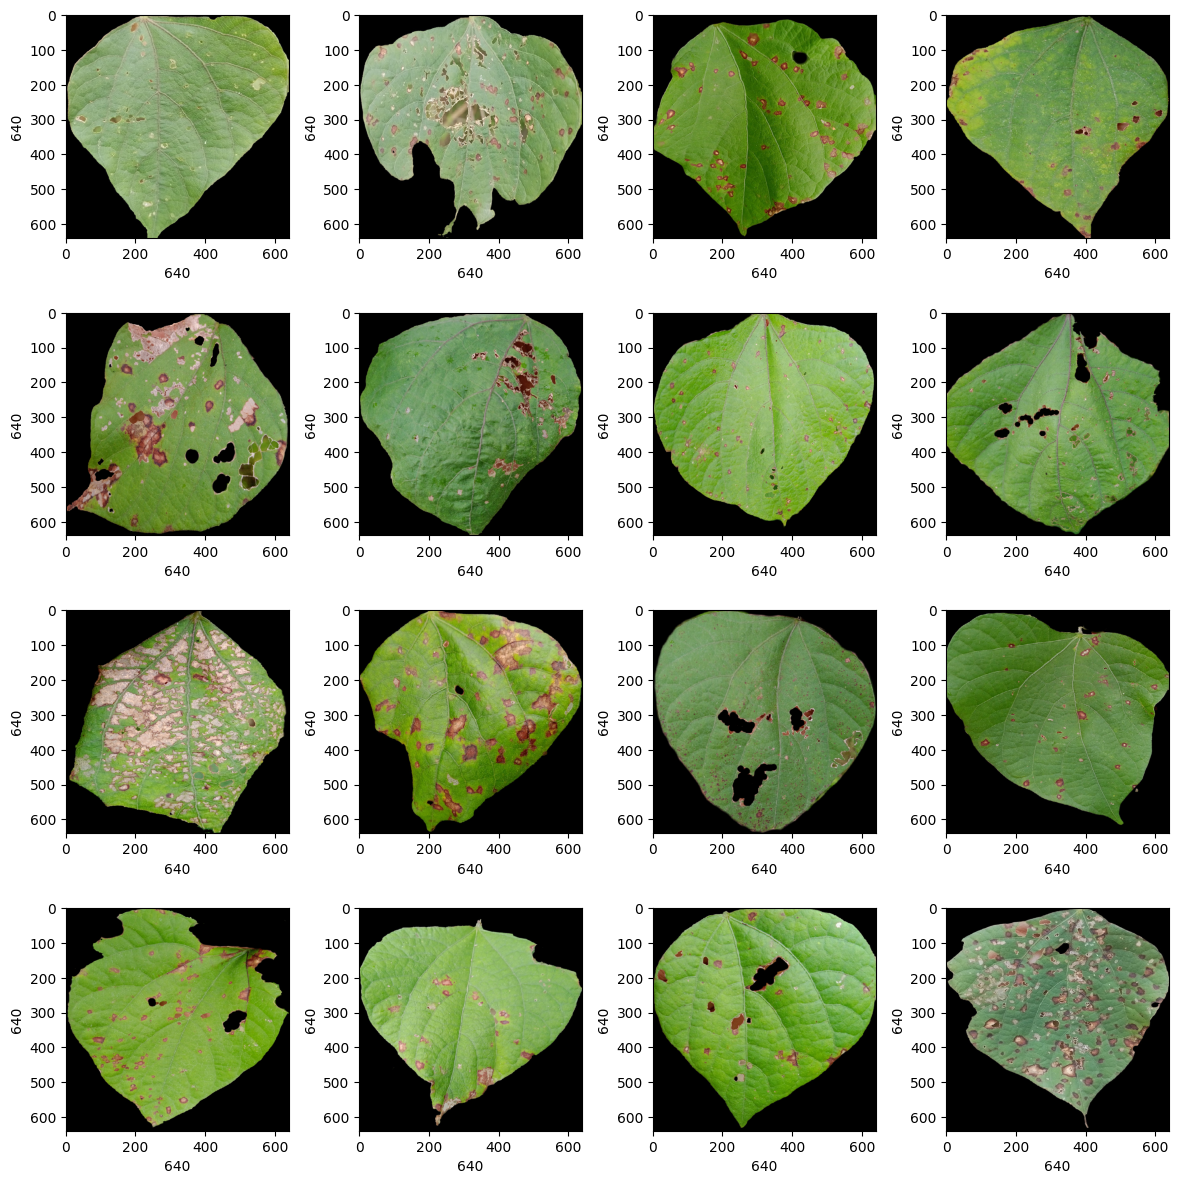

In [ ]:
# Plotting 12 images to check dataset
plt.figure(figsize=(12,12))
path = "/content/drive/My Drive/Plant_images_Try/Broad_beans_Urahi-Cercospora_leaf_spot"
for i in range(1,17):
    plt.subplot(4,4,i)
    plt.tight_layout()
    rand_img = imread(path +'/'+ random.choice(sorted(os.listdir(path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 10)#height of image
    print(os.listdir(path))


**After visualizing the images let us move forward and create a function which will convert the images into a numpy array. It is required because we will normalize our dataset after this.**

In [ ]:
#Converting Images to array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (640,640))
            #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

**Now we will convert all the images into numpy array.**

In [ ]:
dir = "/content/drive/My Drive/Plant_images_Try"
root_dir = listdir(dir)
image_list, label_list = [], []
all_labels = ['Broad_beans_Urahi-Cercospora_leaf_spot', 'Ridge_gourd_Zika-Alternaria_Leaf_Spot', 'Tomato_Leaf-Miner']
binary_labels = [0,1,2]
temp = -1

# Reading and converting image to numpy array
for directory in root_dir:
  plant_image_list = listdir(f"{dir}/{directory}")
  temp += 1
  for files in plant_image_list:
    image_path = f"{dir}/{directory}/{files}"
    image_list.append(convert_image_to_array(image_path))
    label_list.append(binary_labels[temp])

**We will also observe the number of images under different classes to see if the dataset is balanced or not**

In [ ]:
# Visualize the number of classes count
label_counts = pd.DataFrame(label_list).value_counts()
label_counts.head()

0    100
1    100
2    100
dtype: int64

**Next we will observe the shape of the image.**

In [ ]:
image_list[0].shape

(640, 640, 3)

**Checking the total number of the images which is the length of the labels list.**

In [ ]:
label_list = np.array(label_list)
label_list.shape

(300,)

**Next we will use sklearn train_test_split to split the dataset into testing and training data. Here I have taken test size as 0.2 so my data will be divided into 80% training and 20% testing data.**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state = 10)

**Now we will normalize the dataset of our images. As pixel values ranges from 0 to 255 so we will divide each image pixel with 255 to normalize the dataset.**

In [ ]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape( -1, 640,640,3)
x_test = x_test.reshape( -1, 640,640,3)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

**Next we will create a network architecture for the model. We have used different types of layers according to their features namely Conv_2d (It is used to create a convolutional kernel that is convolved with the input layer to produce the output tensor), max_pooling2d (It is a downsampling technique which takes out the maximum value over the window defined by poolsize), flatten (It flattens the input and creates a 1D output), Dense (Dense layer produce the output as the dot product of input and kernel).**

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding="same",input_shape=(640,640,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(16, (3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation="relu"))
model.add(Dense(3, activation="softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 640, 640, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 213, 213, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 213, 213, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 106, 106, 16)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 179776)            0         
                                                                 
 dense (Dense)               (None, 8)                 1

**While compiling the model we need to set the type of loss which will be Binary Crossentropy for our model alongwith this we also need to set the optimizer and the metrics respectively.**

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

**Next we will split the dataset into validation and training data.**

In [ ]:
# Splitting the training data set into training and validation data sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)

**Fitting the model with the data and finding out the accuracy at each epoch to see how our model is learning. Now we will train our model on 25 epochs and a batch size of 50. You can try using more number of epochs to increase accuracy but here we can see that the model has already raeched a very high accuracy so we don't need to run it for more. During each epochs we can see how the model is performing by viewing the training and validation accuracy.**

In [ ]:
# Training the model with early stopping
epochs = 25
batch_size = 50
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
)

Epoch 1/25
4/4 [==============================] - 22s 2s/step - loss: 0.9627 - accuracy: 0.5781 - val_loss: 0.7791 - val_accuracy: 0.5833
Epoch 2/25
4/4 [==============================] - 1s 376ms/step - loss: 0.6785 - accuracy: 0.7448 - val_loss: 0.5549 - val_accuracy: 0.7708
Epoch 3/25
4/4 [==============================] - 1s 376ms/step - loss: 0.4596 - accuracy: 0.8854 - val_loss: 0.4460 - val_accuracy: 0.8750
Epoch 4/25
4/4 [==============================] - 1s 350ms/step - loss: 0.3233 - accuracy: 0.9479 - val_loss: 0.3761 - val_accuracy: 0.8542
Epoch 5/25
4/4 [==============================] - 1s 354ms/step - loss: 0.2471 - accuracy: 0.9688 - val_loss: 0.3182 - val_accuracy: 0.8750
Epoch 6/25
4/4 [==============================] - 1s 374ms/step - loss: 0.1749 - accuracy: 0.9688 - val_loss: 0.3154 - val_accuracy: 0.8333
Epoch 7/25
4/4 [==============================] - 1s 351ms/step - loss: 0.1395 - accuracy: 0.9740 - val_loss: 0.2693 - val_accuracy: 0.9167
Epoch 8/25
4/4 [======

**Saving the model using different techniques.**

In [ ]:
model.save("/content/drive/My Drive/plant_disease.h5")
# serialize model to json
json_model = model.to_json()
#save the model architecture to JSON file
with open('/content/drive/My Drive/plant_model.json', 'w') as json_file:
    json_file.write(json_model)
#saving the weights of the model
model.save_weights('/content/drive/My Drive/plant_model_weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Next we will plot the accuracy of the model for the trainig history.**

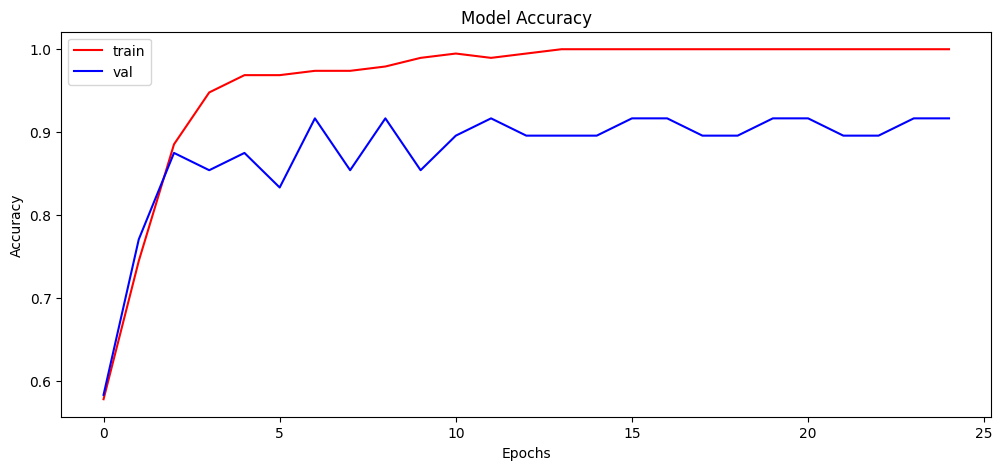

In [ ]:
#Plot the training history
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

**Evaluating the model to know the accuracy of the model.**

In [ ]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
2/2 [==============================] - 2s 687ms/step - loss: 0.0562 - accuracy: 0.9833
Test Accuracy: 98.33333492279053


In [ ]:
print("[INFO] Calculating validation accuracy")
validation_scores = model.evaluate(x_val, y_val)
print(f"Validation Accuracy: {validation_scores[1]*100}")


[INFO] Calculating validation accuracy
2/2 [==============================] - 1s 404ms/step - loss: 0.1994 - accuracy: 0.9167
Validation Accuracy: 91.66666865348816


In [ ]:
print("[INFO] Calculating validation loss")
validation_loss = model.evaluate(x_val, y_val)[0]
print(f"Validation Loss: {validation_loss}")


[INFO] Calculating validation loss
2/2 [==============================] - 0s 45ms/step - loss: 0.1994 - accuracy: 0.9167
Validation Loss: 0.19937856495380402


In [ ]:
print("[INFO] Calculating training loss")
train_loss = model.evaluate(x_train, y_train)[0]
print(f"Training Loss: {train_loss}")


[INFO] Calculating training loss
6/6 [==============================] - 1s 118ms/step - loss: 0.0063 - accuracy: 1.0000
Training Loss: 0.006257433444261551


**Next we will use our model to predict  the testing dataset label.**

In [ ]:
y_pred = model.predict(x_test)

2/2 [==============================] - 0s 71ms/step


**NOw we wll select an image from our dataset and plot it , this is an image we will use here for predicting its disease type for demonstration purpose.**

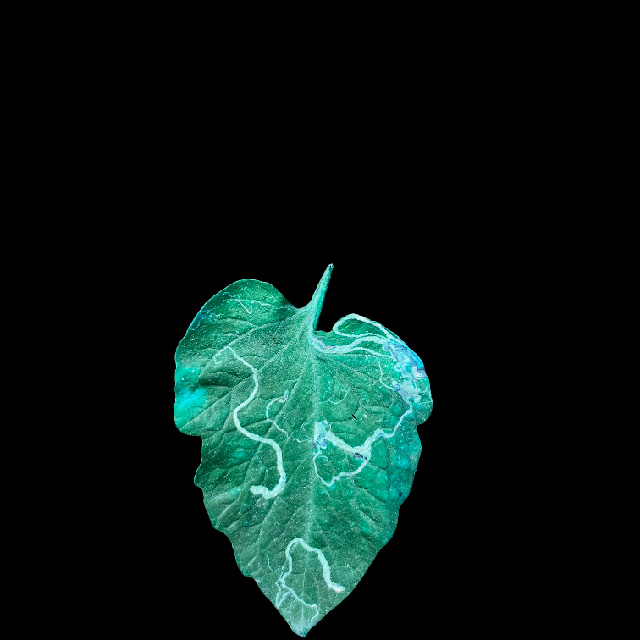

In [ ]:
# Plotting image to compare
img = array_to_img(x_test[8])
img

**Printing out the original and the predicted label.**

In [ ]:
# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",all_labels[np.argmax(y_test[8])])
print("Predicted : ",all_labels[np.argmax(y_pred[8])])

Originally :  Tomato_Leaf-Miner
Predicted :  Tomato_Leaf-Miner


**Conclusion**

**We started with loading the dataset into google colab using google drive and visualizing the images. Normalizing is an important step when working with any type of dataset. After that we created a CNN Model which is further used for predicting the plant diseases using the image supplied to model.**

**This model is highly beneficial as it can be used by different agricultural firms and farmers to increase their yield and stop wastage of crops due to disease.**